In [1]:
import zipfile
import os

zip_file_path = '/content/drive/My Drive/archive (7).zip'
destination_folder = '/content/fire_dataset'

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print(f"Extracted files to: {destination_folder}")


Extracted files to: /content/fire_dataset


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Contracting Path (Encoder)
        self.enc_conv1 = self.conv_block(1, 64)
        self.enc_conv2 = self.conv_block(64, 128)
        self.enc_conv3 = self.conv_block(128, 256)
        self.enc_conv4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Expanding Path (Decoder)
        self.upconv4 = self.upconv_block(1024, 512)
        self.dec_conv4 = self.conv_block(1024, 512)
        self.upconv3 = self.upconv_block(512, 256)
        self.dec_conv3 = self.conv_block(512, 256)
        self.upconv2 = self.upconv_block(256, 128)
        self.dec_conv2 = self.conv_block(256, 128)
        self.upconv1 = self.upconv_block(128, 64)
        self.dec_conv1 = self.conv_block(128, 64)

        # Output layer
        self.output = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        e1 = self.enc_conv1(x)
        e2 = self.enc_conv2(nn.MaxPool2d(2)(e1))
        e3 = self.enc_conv3(nn.MaxPool2d(2)(e2))
        e4 = self.enc_conv4(nn.MaxPool2d(2)(e3))

        # Bottleneck
        b = self.bottleneck(nn.MaxPool2d(2)(e4))

        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec_conv4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec_conv3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec_conv2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec_conv1(d1)

        # Output
        out = self.output(d1)
        return torch.sigmoid(out)

# Instantiate the model
model = UNet()
model = model.cuda() if torch.cuda.is_available() else model


In [3]:
class FireSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_names[idx])
        mask_path = os.path.join(self.mask_dir, self.image_names[idx])  # Mask should have the same name as image

        image = Image.open(image_path).convert("L")  # Assuming grayscale images
        mask = Image.open(mask_path).convert("L")    # Load mask

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor()           # Convert to tensor
])

# Create dataset instances for train and test datasets
train_image_dir = '/content/fire_dataset/Image/Fire'  # Update this to the correct path
train_mask_dir = '/content/fire_dataset/Segmentation_Mask/Fire'    # Update this to the correct path

train_dataset = FireSegmentationDataset(train_image_dir, train_mask_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [4]:
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images = images.cuda() if torch.cuda.is_available() else images
        masks = masks.cuda() if torch.cuda.is_available() else masks
        outputs = model(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader)}')

torch.save(model.state_dict(), 'fire_segmentation_unet.pth')


Epoch [1/10], Loss: 0.06348610818537953
Epoch [2/10], Loss: 0.03326589659607091
Epoch [3/10], Loss: 0.025243608646060085
Epoch [4/10], Loss: 0.02064425659723402
Epoch [5/10], Loss: 0.01745758085290863
Epoch [6/10], Loss: 0.015104238653363498
Epoch [7/10], Loss: 0.013210460518139112
Epoch [8/10], Loss: 0.011895815750999494
Epoch [9/10], Loss: 0.010858938109886876
Epoch [10/10], Loss: 0.01004410049637772


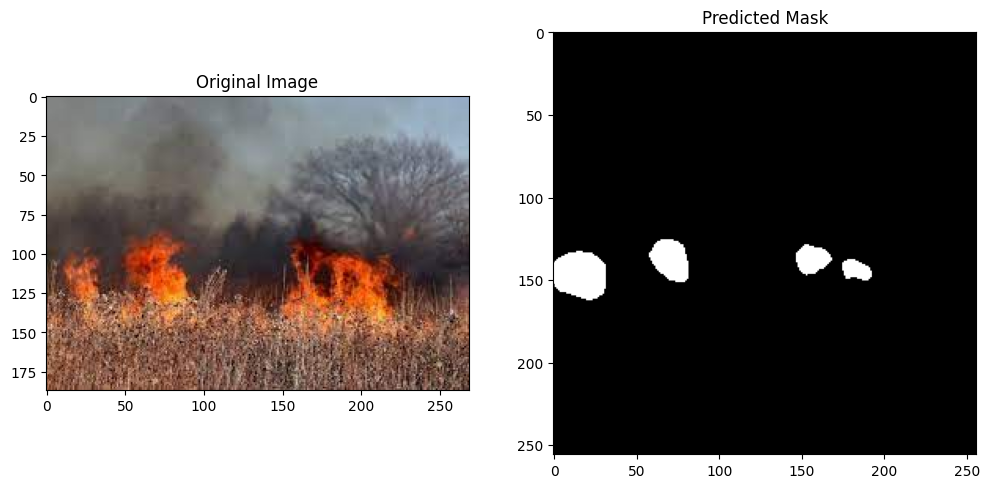

In [5]:
# Load a test image and preprocess it
test_image_path = '/content/drive/MyDrive/Fire_test/images (14).jpeg'
test_image = Image.open(test_image_path).convert("L")  # Convert to grayscale
test_image = transform(test_image)
test_image = test_image.unsqueeze(0)  # Add batch dimension

# Move to GPU if available
test_image = test_image.cuda() if torch.cuda.is_available() else test_image

# Inference
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predicted_mask = model(test_image)

# Post-process the predicted mask
predicted_mask = predicted_mask.cpu().squeeze().numpy()
binary_mask = (predicted_mask > 0.5).astype(float)  # Apply threshold

# Visualize the original image and predicted mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(test_image_path), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title('Predicted Mask')

plt.show()
